# Install Requirements

In [113]:
# !sudo yum install ghostscript -y

In [16]:
# !sudo yum update -y
# !sudo yum install ImageMagick-devel -y

In [3]:
# !pip install pdfplumber

# Imports

In [1]:
import pandas as pd
import pdfplumber
pdfplumber.__version__

'0.6.0'

In [2]:
SOP = "LAB-2448"
sop_file_path = f"data/sop/Andover/{SOP}.pdf"

In [3]:
pdf = pdfplumber.open(sop_file_path)

In [4]:
len(pdf.pages)

19

In [5]:
sample_page = pdf.pages[5]

In [6]:
img = sample_page.to_image()

In [7]:
tf = sample_page.debug_tablefinder()

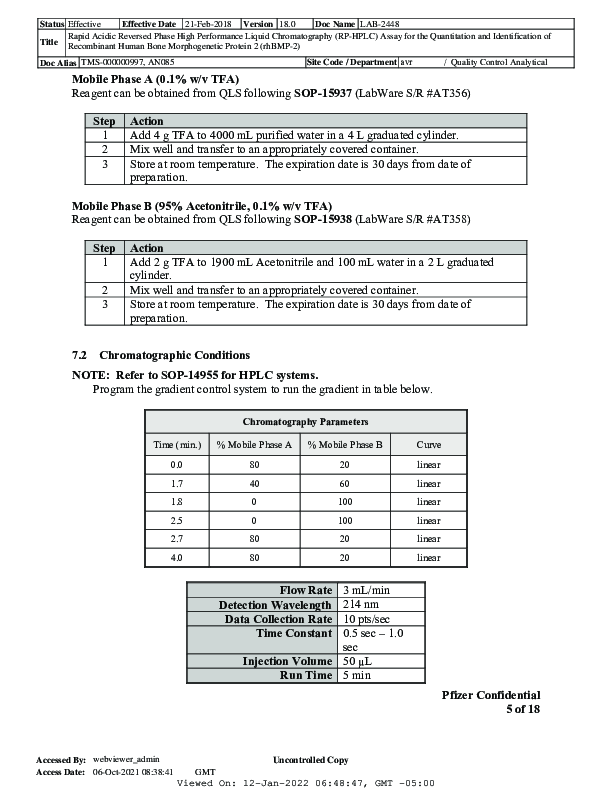

In [8]:
img

## Draw Table Bounding Boxes only

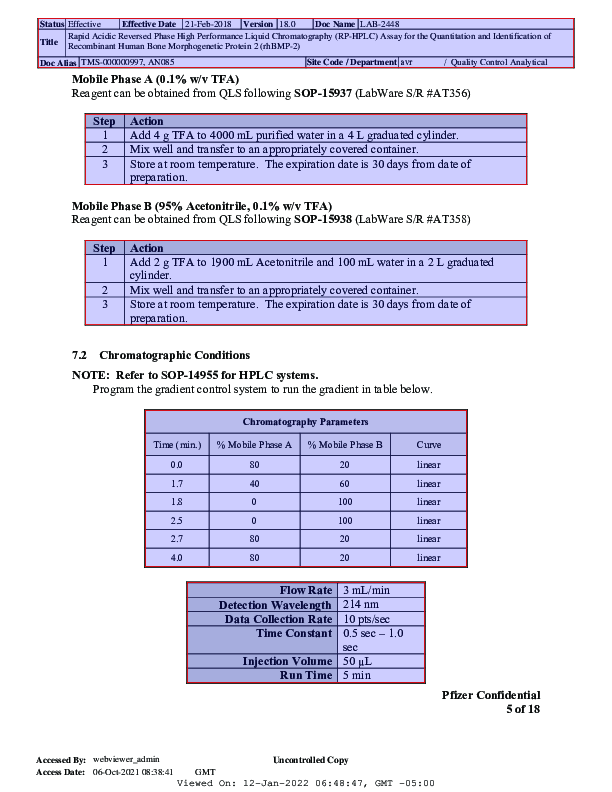

In [9]:
img = sample_page.to_image()
img.draw_rects([item.bbox for item in tf.tables])

## Draw Cell Bounding Boxes Only

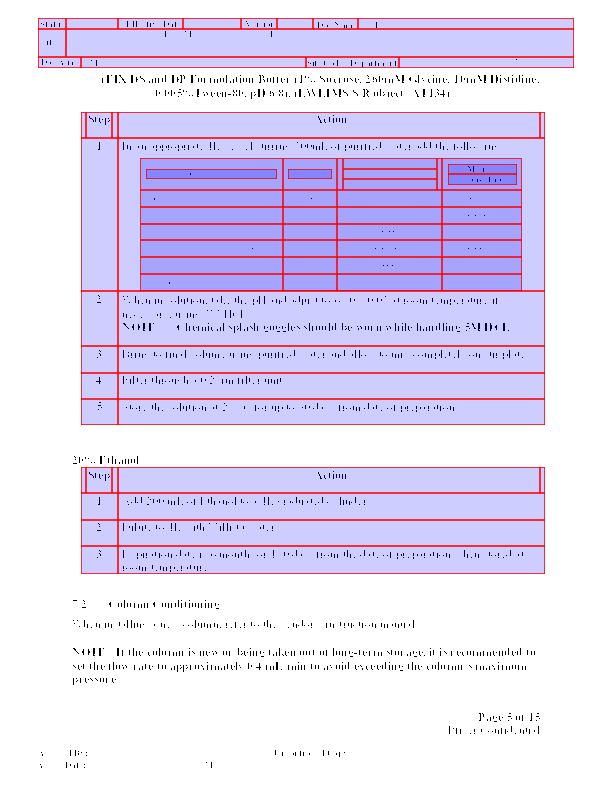

In [34]:
img = sample_page.to_image()
img.draw_rects(tf.cells)

## Draw All Bounding Boxes

In [10]:
dbgimg = img.debug_tablefinder()

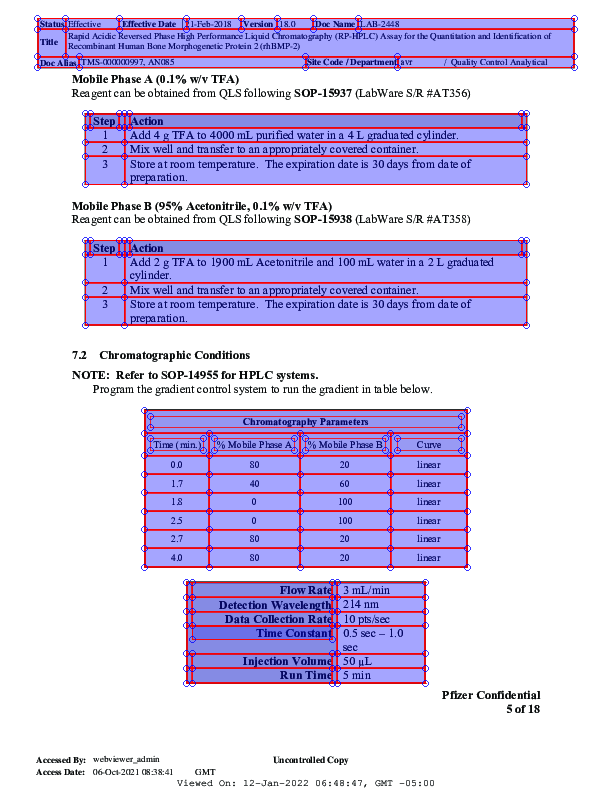

In [11]:
dbgimg.annotated

## Extract Tables as DataFrames

In [12]:
tables = sample_page.extract_tables()
len(tables)

5

In [13]:
table_dfs = []
for table in tables:
    table_dfs.append(pd.DataFrame(table))

In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
table_dfs[0]
table_dfs[1]
table_dfs[2]
table_dfs[3]
table_dfs[4]

,0,1,2,3,4,5,6,7,8,9,10
0,S tatus,E ffective,None,E ffective Date,2 1-Feb-2018,V ersion,1 8.0,None,D oc Name,L AB-2448,None
1,Title,R apid Acidic Reversed Phase High Performance ...,None,None,None,None,None,None,None,None,None
2,D oc Alias,None,"T MS-000000997, AN085",None,None,None,None,S ite Code / Department,None,None,a vr / Quality Control Analytical


,0,1,2,3,4,5
0,,Step,,,Action,
1,1,None,None,Add 4 g TFA to 4000 mL purified water in a 4 L...,None,None
2,2,None,None,Mix well and transfer to an appropriately cove...,None,None
3,3,None,None,Store at room temperature. The expiration dat...,None,None


,0,1,2,3,4,5
0,,Step,,,Action,
1,1,None,None,Add 2 g TFA to 1900 mL Acetonitrile and 100 mL...,None,None
2,2,None,None,Mix well and transfer to an appropriately cove...,None,None
3,3,None,None,Store at room temperature. The expiration dat...,None,None


,0,1,2,3
0,Chromatography Parameters,None,None,None
1,Time (min.),% Mobile Phase A,% Mobile Phase B,Curve
2,0.0,80,20,linear
3,1.7,40,60,linear
4,1.8,0,100,linear
5,2.5,0,100,linear
6,2.7,80,20,linear
7,4.0,80,20,linear


,0,1,2,3
0,,Flow Rate,,3 mL/min
1,,Detection Wavelength,,214 nm
2,,Data Collection Rate,,10 pts/sec
3,Time Constant,Time Constant,None,0.5 sec –1.0 \nsec
4,,Injection Volume,,50 µL
5,,Run Time,,5 min


# Detect Tables on All SOPs

In [38]:
# make directory for storing table detections
# !mkdir --parent data/sop_tables_pdfplumber/ data/sop_tables_pdfplumber/GC data/sop_tables_pdfplumber/Andover data/sop_tables_pdfplumber/Kalamazoo data/sop_tables_pdfplumber/McPherson

In [16]:
import os
import tqdm

In [17]:
SOP_DIR = "data/sop"

SOP_TABLES_DIR = "data/sop_tables_pdfplumber"

SOP_TYPES = [
    "GC",
    "Andover",
    "Kalamazoo",
    "McPherson"
]

In [30]:
def detect_tables(filename):
    pdf = pdfplumber.open(filename)
    
    pdf_images_with_table_boxes = []
    table_dfs_per_page = []
    for page_idx, page in enumerate(pdf.pages):
        
        # get bounding boxes on page as an image
        page_img = page.to_image()
        page_img_debug = page_img.debug_tablefinder()
        
        pdf_images_with_table_boxes.append(page_img_debug.annotated)
        
        # extract tables as pandas DataFrames
        tables = page.extract_tables()

        table_dfs = []
        for table_idx, table in enumerate(tables):
            try:
                table_dfs.append(pd.DataFrame(table))
            except:
                print(f"Error converting table to dataframe!\nFilename:{filename}\tPage:{page_idx}\tTable:{table_idx}\nData:{table}\n")
                
        table_dfs_per_page.append(table_dfs)

    return pdf_images_with_table_boxes, table_dfs_per_page

In [34]:
def images_to_pdf(images, filename):
    if images:
        images[0].save(filename, "PDF" ,resolution=100.0, save_all=True, append_images=images[1:])

In [35]:
def tables_to_csv(tables, dir):
    if not os.path.exists(dir):
        os.mkdir(dir)
        
    for page_idx, page_tables in enumerate(tables):
        for table_idx, table in enumerate(page_tables):
            table.to_csv(f"{dir}/table_{page_idx}_{table_idx}.csv")

In [31]:
%time detected_tables, table_dfs = detect_tables(sop_file_path)

CPU times: user 11.2 s, sys: 136 ms, total: 11.4 s
Wall time: 10.9 s


In [40]:
for sop_type in SOP_TYPES:
    _subdir = os.path.join(SOP_DIR, sop_type)
    
    for sop_filename in tqdm.tqdm(os.listdir(_subdir), desc=f"{sop_type} SOPs"):
        if sop_filename.endswith('.pdf'):
            _sop_file_id = sop_filename.rstrip('.pdf')
            
            _sop_file_path = os.path.join(SOP_DIR, sop_type, sop_filename)
            _sop_tables_file_path = os.path.join(SOP_TABLES_DIR, sop_type, sop_filename)
            _sop_tables_dir_path = os.path.join(SOP_TABLES_DIR, sop_type, _sop_file_id)
            
            detected_tables, tables_dfs = detect_tables(filename=_sop_file_path)
            images_to_pdf(images=detected_tables, filename=_sop_tables_file_path)
            tables_to_csv(tables=tables_dfs, dir=_sop_tables_dir_path)
            
        else:
            print(f"Skipping Invalid File:{os.path.join(_subdir, sop_filename)}!!")

Andover SOPs: 100%|██████████| 13/13 [02:06<00:00,  9.77s/it]


Skipping Invalid File:data/sop/Andover/.ipynb_checkpoints!!


McPherson SOPs: 100%|██████████| 8/8 [00:28<00:00,  3.51s/it]

Skipping Invalid File:data/sop/McPherson/.ipynb_checkpoints!!
